In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('2021_master.csv')

/Users/danielmarron/.pyenv/versions/le_kingmakers/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0,1,5,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## drop duplicates for id - multiple tweets picked up under searches for different figures where they are all mentioned

In [4]:
df = df.drop_duplicates('id').reset_index(drop=True)

In [5]:
# at row 3384 somehow the headers have crept in... needs to be removed, addressed in this notebook for now
df = df.drop(index=3384)

In [6]:
df.shape

(120635, 14)

In [7]:
#for some reason appears to be reading in the 'date' title and trying to convert... ignore for now
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [8]:
int_types = ['replies_count', 'retweets_count', 'likes_count']

In [9]:
df[int_types] = df[int_types].astype(int)

In [10]:
df.dtypes

id                         object
conversation_id            object
created_at                 object
date               datetime64[ns]
time                       object
user_id                    object
tweet                      object
language                   object
replies_count               int64
retweets_count              int64
likes_count                 int64
hashtags                   object
geo                        object
figure                     object
dtype: object

## Import models

In [11]:
import joblib

In [12]:
model = joblib.load('../le_kingmakers/model2.joblib')

In [13]:
model

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('clean_text', TextPreprocess()),
                                 ('convert_text', TextConvertAbbv())])),
                ('vectorizer', TfidfVectorizer(max_df=0.2, ngram_range=(1, 2))),
                ('model', MultinomialNB())])

In [14]:
%time
df['prediction'] = model.predict(df['tweet'])

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


In [15]:
#the bayes model predicts 0 or 4
sentiment_map = {0:-1, 4:1}

In [16]:
df['prediction'] = df['prediction'].map(sentiment_map)

In [17]:
df.prediction.value_counts()

-1    66602
 1    54033
Name: prediction, dtype: int64

### new class needs to be created for the table that is going to be just days, figure, predictions...
- need a get tweet function? to get the id of the tweet and print whats been said, return the retweets count


## Generating a popularity formula

### Formula is:


In [18]:
likes_weighting = 0.5
retweets_weighting = 1
df['popularity'] = df['prediction'] + (df['prediction']*df['likes_count']*likes_weighting) + \
                      (df['prediction']*df['retweets_count']*retweets_weighting)


In [19]:
#create groups by MP, then can get group and do the data analysis
figure_groups = df.groupby('figure')

In [20]:
#create dataframe of tweets for mh, summing up the predictions and likes_counts
mh = figure_groups.get_group('matthancock').groupby('date',as_index=False).agg({'popularity':'sum','likes_count':'sum',})
mh.head(2)

,date,popularity,likes_count
0,2021-01-01,-24.5,105
1,2021-01-02,-25.5,275


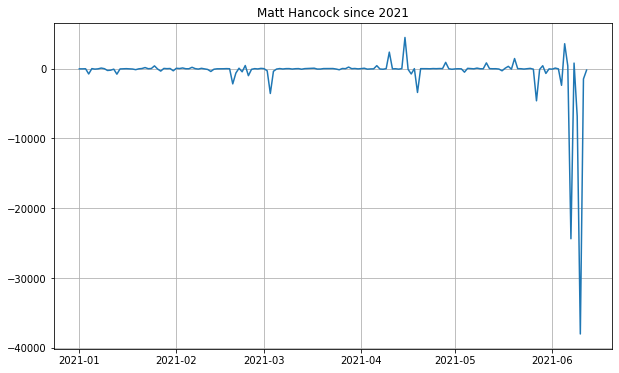

In [21]:
fig = plt.figure(figsize=(10,6))
plt.grid('minor')
plt.plot(mh.date,mh.popularity)
plt.title('Matt Hancock since 2021')
plt.show()

In [22]:
#lets try and find the negative tweets...
#getting a battering following the allegations from dominic cummings and defending himself against MPs 
#- think this is the case

In [23]:
mh_test = figure_groups.get_group('matthancock')

In [24]:
negative_search = mh_test[(mh_test['date']>'2021-06-01')&(mh_test['date']<'2021-06-15')&(mh_test['prediction']==-1)]

In [25]:
negative_search.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'user_id',
       'tweet', 'language', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'geo', 'figure', 'prediction', 'popularity'],
      dtype='object')

In [26]:
negative_search.sort_values(by='likes_count', ascending=False).iloc[:6,:].tweet.values

array(['Matt Hancock: “There was no national shortage of PPE”  https://t.co/2dpBkiMuZA',
       'Matt Hancock saying they didn’t test people sent back into care homes because they didn’t test asymptomatic cases will really annoy Matt Hancock who said they didn’t test people because of a lack of tests which will really annoy Matt Hancock who said everyone would be tested.',
       'How can @MattHancock stand there and say “there is no room for complacency” after delaying *three weeks* before putting India on red list once Delta variant discovered in the UK?  Shameless',
       'Today: ▪️Govt broke the law on contracts ▪️They want to break their “oven ready” Brexit deal ▪️They’re threatening to break international law ▪️It’s revealed Matt Hancock knew re care homes risk in March 2020 ▪️PM took jet to talk about climate crisis  And the day isn’t over yet',
       'CHRIST  Matt Hancock is defending the Govt’s decision to not cover people’s salaries when required to self-isolate  He actuall

In [27]:
positive_search=mh_test[(mh_test['date']>'2021-04-10')&(mh_test['date']<'2021-04-15')&(mh_test['prediction']==1)]

In [28]:
positive_search.sort_values(by='likes_count', ascending=False).tweet.values[:5]

array(["NHS workers in Scotland will get a 4% pay rise. I've just signed the petition demanding @MattHancock and @RishiSunak give #NHS staff in England a REAL payrise. 1% is just not good enough. Will you join me?  https://t.co/jBR90Wp9ei",
       'Listen 🎧 to my interview with Ali Parsa - CEO @babylonhealth   cc: @Gil_Bashe @NHSEngland @SpiritDigitalUK @MSF_uk @UrsBolt @UiPath @JohnNosta @ZGJR @zajctjasa @daniel_kraft @innonurse @MattHancock @SiemensHealth @_FaceSA @ValaAfshar @SpirosMargaris @drjohnwhyte  #digitalhealth',
       'Important article by @EveSimmns in today’s @mailonsundaySTL  I comment on how so many sexualised #online images are unhelpful for #youngpeople and their #mentalhealth #fitspo @rcpsych @RcpsychCAP @YoungMindsUK @psych_cypf @cypnow @BPSOfficial @ACPtherapy @IFT_london @MattHancock',
       'Great message from @MattHancock thank you! Derbyshire Conservative’s are really delivering for #Derbyshire residents. 55% of people vaccinated - ahead of national average. 

## making an example for borisjohnson for LDA

In [29]:
boris = figure_groups.get_group('borisjohnson')

In [30]:
boris_negative = boris[boris['prediction'] == -1]

## REMOVE AFTER

In [31]:
# negative_search = boris_negative.copy() #just to avoid changing the code below

# LDA Modelling

In [32]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis 
# The pyLDAvis gensim name changed. When I use gensim_models rather than gensim the interactive viz works.# don't skip this
# import matplotlib.pyplot as plt
# %matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/danielmarron/.pyenv/versions/le_kingmakers/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [33]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import string
from nltk import word_tokenize

## Add to stopwords:


In [34]:
added_words = ['matthancock','matt','hancock','get','say','amp', 'boris', 'borisjohnson', 'johnson']
stop_words.extend(added_words)
# stop_words=set(stop_words)
len(stop_words)

188

In [35]:
#new basic data cleaning being used

def preprocess_tweet(text):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # convert text to lower-case
    nopunc = nopunc.lower()
    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', nopunc)
    nopunc = re.sub(r'http\S+', '', nopunc)
    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)
    # remove the # in #hashtag
    nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)
    # remove repeated characters
#     nopunc = word_tokenize(nopunc)
    # remove stopwords from final word list
#     return [word for word in nopunc if word not in stopwords.words('english')]
    return nopunc

In [36]:
# raw tweet
negative_search.tweet.values[0]

'Matt Hancock said the Covid-19 mutation that originated in India now makes up 91% of new cases in the UK...   https://t.co/9Ro8oh97ie'

In [37]:
#result:
preprocess_tweet(negative_search.tweet.values[0])

'matt hancock said the covid19 mutation that originated in india now makes up 91 of new cases in the uk   '

## create new dateframe to do the lda - this is on negative tweets only

In [38]:
lda_df = negative_search #this is from dates above
lda_df.shape

(5360, 16)

In [39]:
lda_df['tweet'] = lda_df.tweet.map(preprocess_tweet)

<ipython-input-39-4a6a154d9d71>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lda_df['tweet'] = lda_df.tweet.map(preprocess_tweet)


## preprocess dataframe

In [40]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [41]:
data_words = list(sent_to_words(lda_df['tweet']))

## build bigram and trigram models

In [42]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100) 

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

['matt', 'hancock', 'said', 'the', 'covid', 'mutation', 'that', 'originated', 'in', 'india', 'now', 'makes', 'up', 'of', 'new', 'cases', 'in', 'the', 'uk']


## Remove Stopwords, Make Bigrams and Lemmatize

In [43]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [44]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [45]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [46]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en #had to do this in terminal
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm")

# import en_core_web_sm - this bit was just a check, can delete
# nlp = en_core_web_sm.load()

#### takes time...:

In [47]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['say', 'covid', 'mutation', 'originate', 'india', 'make', 'new', 'case']]


## Create the Dictionary and Corpus needed for Topic Modeling

In [48]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [49]:
id2word[30]

'geezadiamondme'

In [50]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]] #try this out - break down of each tweet/sentence

## build LDA model

In [51]:
#these are all the parameters to play with
%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1, #how often parameters should be updated #0 for batch learning
                                           chunksize=100,
                                           passes=10, #total number of training passes
                                           alpha='auto',
                                           per_word_topics=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


In [52]:
#hidden for now - just a visual on the data
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.016*"find" + 0.015*"try" + 0.014*"answer" + 0.012*"mask" + 0.011*"maybe" '
  '+ 0.010*"ppaulcharle" + 0.009*"call" + 0.009*"resign" + 0.009*"remember" + '
  '0.008*"lose"'),
 (1,
  '0.035*"people" + 0.024*"know" + 0.016*"think" + 0.016*"still" + 0.014*"nhs" '
  '+ 0.014*"need" + 0.013*"liar" + 0.013*"tell" + 0.012*"time" + '
  '0.011*"believe"'),
 (2,
  '0.017*"get" + 0.016*"s" + 0.015*"test" + 0.015*"really" + 0.014*"child" + '
  '0.010*"do" + 0.010*"question" + 0.009*"england" + 0.009*"show" + '
  '0.008*"risk"'),
 (3,
  '0.035*"lie" + 0.023*"covid" + 0.019*"say" + 0.019*"go" + 0.017*"make" + '
  '0.016*"death" + 0.012*"government" + 0.012*"tory" + 0.012*"never" + '
  '0.011*"ppe"'),
 (4,
  '0.041*"vaccine" + 0.020*"andrewbowiemp" + 0.017*"take" + 0.016*"day" + '
  '0.015*"way" + 0.012*"back" + 0.010*"money" + 0.010*"also" + '
  '0.009*"scotland" + 0.008*"wrong"')]


## judging model score

In [53]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
#suppose higher the better?


Perplexity:  -8.749543974993754

Coherence Score:  0.2791675357977853


In [54]:
#could grid search to find optimum coherence score? 9 is best so far

## visualise

In [55]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.319225  0.035417       1        1  29.915673
1     -0.117262  0.284566       2        1  24.961775
2     -0.068983 -0.099974       3        1  16.422598
4     -0.077282 -0.134915       4        1  15.959064
0     -0.055698 -0.085094       5        1  12.740890, topic_info=         Term        Freq       Total Category  logprob  loglift
103       lie  617.000000  617.000000  Default  30.0000  30.0000
16     people  512.000000  512.000000  Default  29.0000  29.0000
295   vaccine  384.000000  384.000000  Default  28.0000  28.0000
89       know  356.000000  356.000000  Default  27.0000  27.0000
1       covid  403.000000  403.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
2407     form   35.325256   36.108593   Topic5  -5.3552   2.0384
356     whole   35.015658   35.799721   Topic5  -5.3640   2.0382
29     doctor   33.049838   33.830969   Topic5  -5.4218   2.0370
1945      gon   33.104229   33.896948   Topic5  -5.4202   2.0367
138     exist   33.254150   34.076721   Topic5  -5.4156   2.0359

[189 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1074      4  0.990475       actually
751       4  0.985195          admit
596       3  0.995422          allow
780       4  0.988624           also
358       4  0.993344  andrewbowiemp
...     ...       ...            ...
242       2  0.944377           well
356       5  0.977661          whole
196       2  0.996762           work
713       4  0.992051          wrong
583       1  0.995536            yet

[167 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1])

## Building LDA Mallet Model

In [56]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

AttributeError: module 'gensim.models' has no attribute 'wrappers'